# Import Python functionality

In [ ]:
!pip install -q kaggle
!pip install --user --upgrade tensorflow-model-optimization

Requirement already up-to-date: tensorflow-model-optimization in /root/.local/lib/python3.6/site-packages (0.5.0)


In [ ]:
import os
import cv2
import random
import numpy as np
import skimage.io as io
import tensorflow as tf

from shutil import copyfile
from google.colab import drive
from pycocotools.coco import COCO
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_model_optimization as tfmot

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# Dataset

## Get files
Since I'm using a GPU to train the models, there is less available memory and I'm not able to do all of the necessary steps in this notebook.  To work around this, I'm going to generate the dataset in a separate notebook (coco.ipyb) and store in my google drive.  This notebook will read data from the google drive and copy it to the local drive.  I found this to be necessary as any operation involving the dataset was EXTREMELY slow.

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)

# Path for local resources
path_to_train_dir = '/content/COCOdataset/train'
path_to_test_dir = '/content/COCOdataset/val'

In [ ]:
# Create the expected directory structure on the local drive
!rm -rf /content/COCOdataset
os.mkdir('/content/COCOdataset')
os.mkdir('/content/COCOdataset/val')
os.mkdir('/content/COCOdataset/val/person')
os.mkdir('/content/COCOdataset/train')
os.mkdir('/content/COCOdataset/train/person')
os.chdir('/content/')

In [ ]:
# Copy validation files from GDrive to local drive to speed things up
# NOTE: I'm doing validation and training in two steps.  It takes a long time to
#       copy the files and I wanted to know when the first step was complete
!find /content/drive/MyDrive/Colab\ Notebooks/CS581/Project/COCOdataset/val/person -name "*.jpg" -print0 | xargs -0 cp -t /content/COCOdataset/val/person
!ls -l /content/COCOdataset/val/person | wc -l

2694


In [ ]:
# Copy training files from GDrive to local drive to speed things up
!find /content/drive/MyDrive/Colab\ Notebooks/CS581/Project/COCOdataset/train/person -name "*.jpg" -print0 | xargs -0 cp -t /content/COCOdataset/train/person
!ls -l /content/COCOdataset/train/person | wc -l

64116


## Train, test and validation sets

In [ ]:
# Training dataset - 80% of the training data
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_train_dir,
    validation_split=0.2,
    subset="training",
    seed=0,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 64115 files belonging to 1 classes.
Using 51292 files for training.


In [ ]:
# Validation dataset - 20% of the training data
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_train_dir,
    validation_split=0.2,
    subset="validation",
    seed=0,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 64115 files belonging to 1 classes.
Using 12823 files for validation.


In [ ]:
# Use the 'validation' data for testing
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_test_dir,
    seed=0,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 2693 files belonging to 1 classes.


In [ ]:
# Verify that we only have the single class of interest
class_names = train_dataset.class_names
class_names

['person']

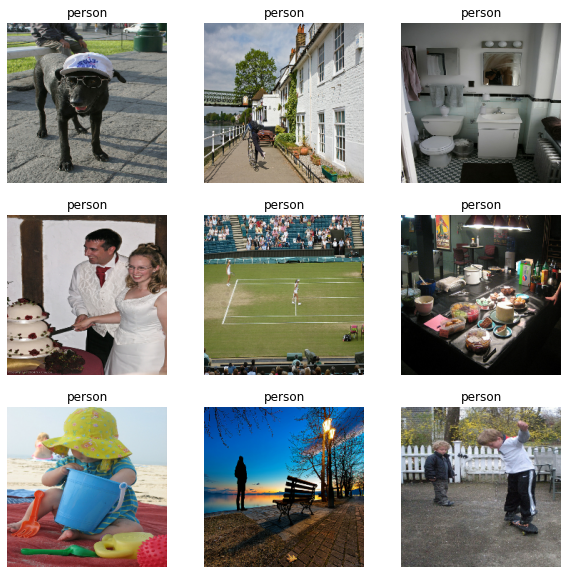

In [ ]:
# Display some images to get an idea about the types of images included
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Data augmentation

In [ ]:
# Use buffered prefetching to load images from disk w/o having I/O become blocking
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Apply horizontal flip and random rotation to generate 'new' images from the
# original dataset.
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

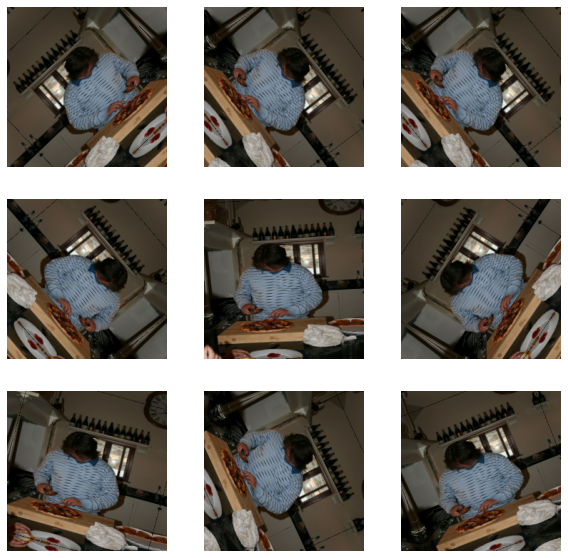

In [ ]:
# Show some examples of the data augmentation
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Model

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [ ]:
# Make sure the model is frozen
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Evaluate the model on the testing dataset before fine-tuning
loss0, accuracy0 = model.evaluate(test_dataset)

85/85 [==============================] - 11s 134ms/step - loss: 0.9402 - accuracy: 0.5938


In [ ]:
initial_epochs = 20
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
1603/1603 [==============================] - 427s 266ms/step - loss: 0.6883 - accuracy: 0.6375 - val_loss: 0.9023 - val_accuracy: 0.4878
Epoch 2/20
1603/1603 [==============================] - 426s 266ms/step - loss: 0.6169 - accuracy: 0.6509 - val_loss: 0.8529 - val_accuracy: 0.4927
Epoch 3/20
1603/1603 [==============================] - 426s 266ms/step - loss: 0.5022 - accuracy: 0.7287 - val_loss: 0.7090 - val_accuracy: 0.4976
Epoch 4/20
1603/1603 [==============================] - 431s 269ms/step - loss: 0.4468 - accuracy: 0.7810 - val_loss: 0.6314 - val_accuracy: 0.5024
Epoch 5/20
1603/1603 [==============================] - 431s 270ms/step - loss: 0.3961 - accuracy: 0.8090 - val_loss: 0.5900 - val_accuracy: 0.5122
Epoch 6/20
1603/1603 [==============================] - 430s 268ms/step - loss: 0.3302 - accuracy: 0.8540 - val_loss: 0.5127 - val_accuracy: 0.5463
Epoch 7/20
1603/1603 [==============================] - 460s 286ms/step - loss: 0.3336 - accuracy: 0.8455 - val_

## After training

In [ ]:
loss1, accuracy1 = model.evaluate(validation_dataset)


85/85 [==============================] - 12s 136ms/step - loss: 0.1735 - accuracy: 0.9122


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
# Add data here

### Unfreeze the top layers of the model

In [ ]:
# Unfreeze the top layers of the model
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
# Now train the model using the new dataset
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 20/30
1603/1603 [==============================] - 460s 286ms/step - loss: 0.0578 - accuracy: 0.9878 - val_loss: 0.0403 - val_accuracy: 0.9902
Epoch 21/30
1603/1603 [==============================] - 444s 276ms/step - loss: 0.0228 - accuracy: 0.9976 - val_loss: 0.0145 - val_accuracy: 1.0000
Epoch 22/30
1603/1603 [==============================] - 429s 267ms/step - loss: 0.0184 - accuracy: 0.9988 - val_loss: 0.0150 - val_accuracy: 0.9951
Epoch 23/30
1603/1603 [==============================] - 431s 269ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0121 - val_accuracy: 0.9951
Epoch 24/30
1603/1603 [==============================] - 429s 267ms/step - loss: 0.0119 - accuracy: 0.9964 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 25/30
1603/1603 [==============================] - 432s 270ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 26/30
1603/1603 [==============================] - 410s 255ms/step - loss: 0.0042 - accuracy: 0.9988

In [ ]:
# Evaluate the model accuracy after re-training
loss1, accuracy1 = model.evaluate(test_dataset)

85/85 [==============================] - 14s 170ms/step - loss: 1.0609e-04 - accuracy: 1.0000


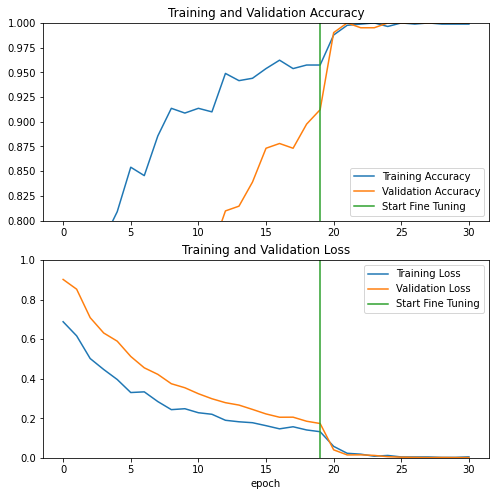

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predictions:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


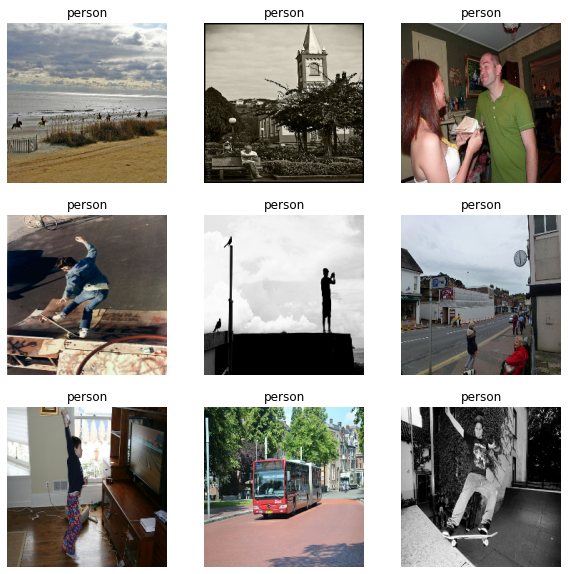

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

TFLite - 16 bit

In [ ]:
converter16 = tf.lite.TFLiteConverter.from_keras_model(model)
converter16.optimizations = [tf.lite.Optimize.DEFAULT]
converter16.target_spec.supported_types = [tf.float16]

In [ ]:
tflite_16_model = converter16.convert()

INFO:tensorflow:Assets written to: /tmp/tmp1bs3_cpi/assets


INFO:tensorflow:Assets written to: /tmp/tmp1bs3_cpi/assets


In [ ]:
detect_tf_lite_path="/content/drive/MyDrive/Colab Notebooks/CS581/Project/detect.tflite"
with open(detect_tf_lite_path, 'wb') as f:
  f.write(tflite_p16_model)